In [1]:
#! pip install umap-learn

In [2]:
# %reset
# Para visualización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
from IPython.display import Audio, Markdown, Image
import pylab
import seaborn as sns

# Números y Datos
import numpy as np
import pandas as pd

# Archivos
import urllib.request
import glob

# Análisis de sonido
import spotipy 

# Machine learning
# importar los paquetes para clustering
from sklearn.preprocessing import StandardScaler

# To work with categorical types
from pandas.api.types import CategoricalDtype

# Clustering (scipy)
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster

# Clustering (sklearn)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics.pairwise import euclidean_distances

from funciones import plot_silhouette
from funciones import plot_silhouettes_and_sses
from funciones import get_silhouette_avg
from funciones import get_sse
from funciones import vanDongen

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, Isomap, SpectralEmbedding, TSNE

from umap import UMAP

Se cargan los datasets.

In [3]:
metadata_original = pd.read_csv('../data/metadata.csv', index_col='id')
audio_features_original = pd.read_csv('../data/audio_features.csv', index_col='id')
audio_analysis_original = pd.read_csv('../data/audio_analysis.csv', index_col='id')

Se seleccionan únicamente las variables numéricas

In [4]:
audio_features = audio_features_original[['acousticness','danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness','loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']]

In [5]:
audio_features.dtypes

acousticness        float64
danceability        float64
duration_ms           int64
energy              float64
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
tempo               float64
time_signature        int64
valence             float64
dtype: object

In [6]:
audio_features.shape

(2206, 13)

# Experiencia 1: KMeans

## audio_features

Para audio_features, se determina la cantidad de clusters utilizando silhuette y SSE.

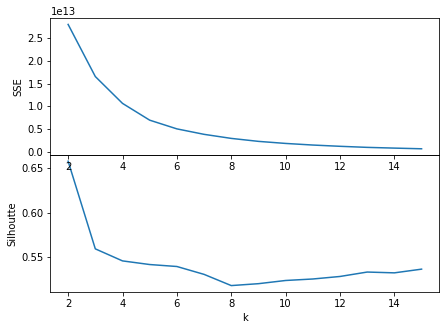

In [7]:
plot_silhouettes_and_sses(audio_features, 15)

¿Cuál sería el k ideal? El quiebre de SSE lo tenemos más o menos en 5 o en 6. Con valores más altos de k el silhouette baja demasiado.

In [8]:
get_silhouette_avg(audio_features, 5)

0.5411973992224247

In [9]:
get_silhouette_avg(audio_features, 6)

0.5389668044713934

El silhouette promedio obtenido en 5 es mayor que en 6. Ya con 7 y 8 el silhouette parece bajar demasiado y no obtenemos mucha ganancia en el SSE.

In [10]:
get_sse(audio_features, 5)

6990451230224.02

In [11]:
get_sse(audio_features, 6)

5085389489695.948

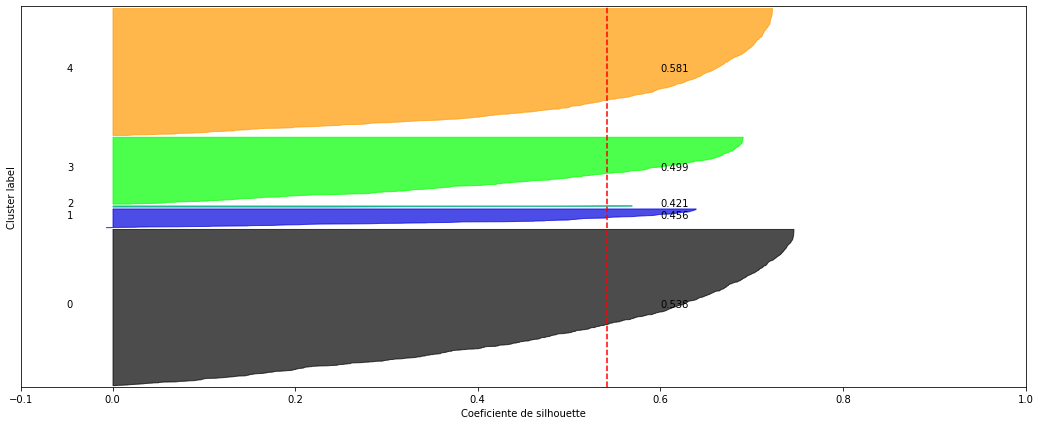

In [12]:
plot_silhouette(audio_features, 5)

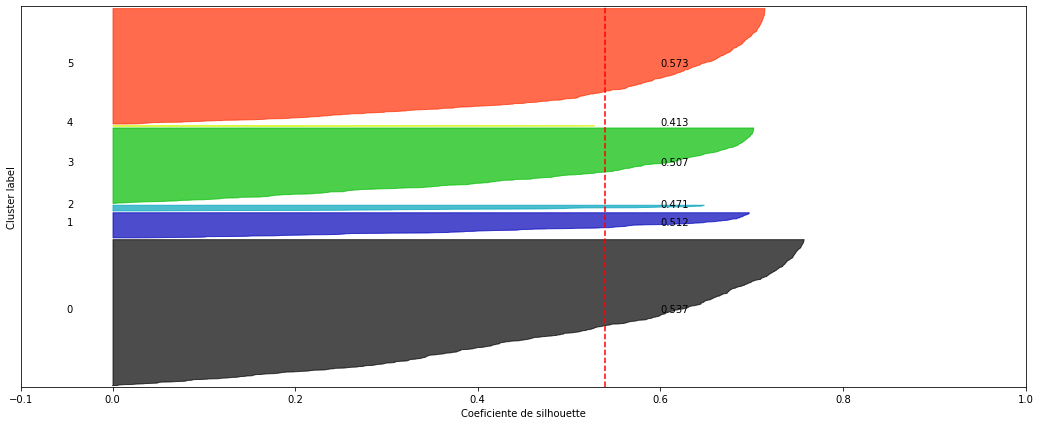

In [13]:
plot_silhouette(audio_features, 6)

Conclusión: El valor ideal pareciera ser k = 5.

## audio_analysis

Para audio_analysis, se determina la cantidad de clusters utilizando silhuette y SSE.

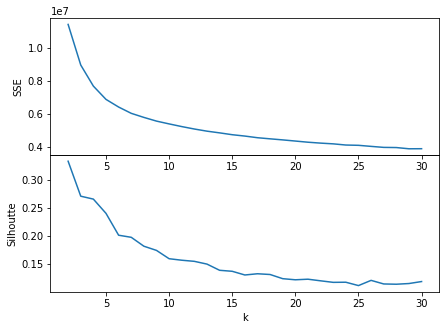

In [14]:
plot_silhouettes_and_sses(audio_analysis_original, 30)

¿Qué valor de k podría ser mejor? Pareciera estar entre k = 3 y k = 10.

In [15]:
sils_sses = []
for k in range(3, 11):
    sils_sses.append([k, get_silhouette_avg(audio_analysis_original, k), get_sse(audio_analysis_original, k)])
pd.DataFrame(sils_sses, columns=['k', 'silhouette', 'sse'])

,k,silhouette,sse
0,3,0.270697,8.979641e+06
1,4,0.265544,7.692301e+06
2,5,0.240368,6.881081e+06
3,6,0.201742,6.413605e+06
4,7,0.198060,6.029040e+06
5,8,0.182327,5.780614e+06
6,9,0.174923,5.554529e+06
7,10,0.160212,5.383437e+06


El silhouette promedio es bastante malo. Cambiará algo si le quito las dos variables que en el preprocesamiento vimos que estaban muy correlacionadas con otras?

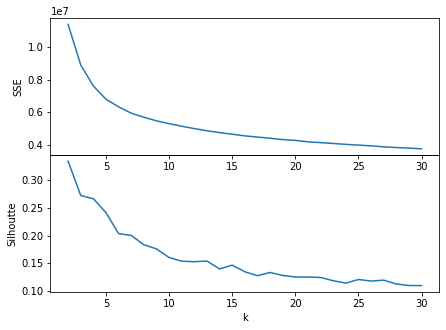

In [16]:
audio_analysis_sin_vars = audio_analysis_original.drop(['timbre_std_10', 'timbre_std_7'], axis = 1)
plot_silhouettes_and_sses(audio_analysis_sin_vars, 30)

Es lo mismo. ¿Será que le molestan los outliers? KMeans es muy sensible a outliers.

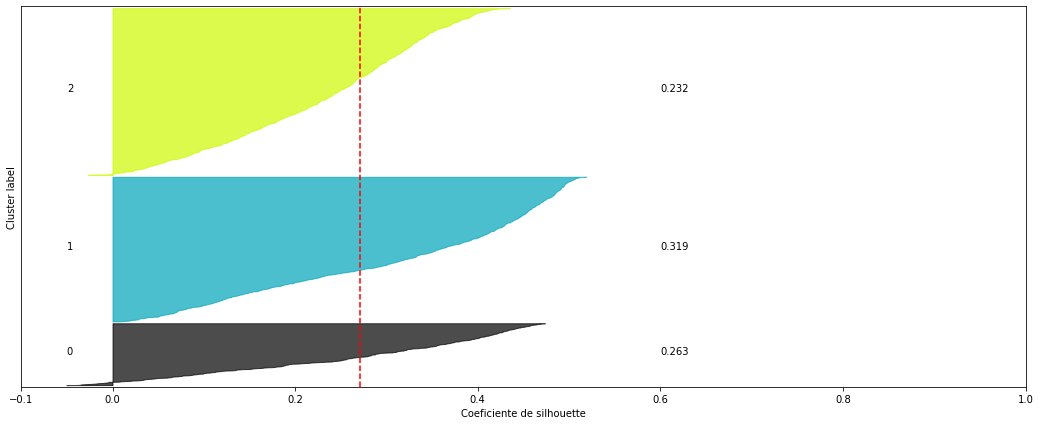

In [17]:
plot_silhouette(audio_analysis_original, 3)

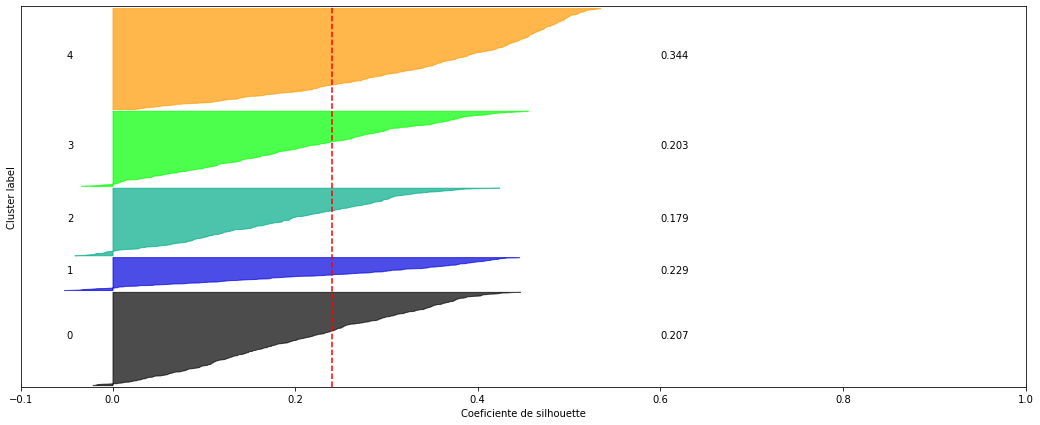

In [18]:
plot_silhouette(audio_analysis_original, 5)

## audio_features y audio_analysis

Para ambos dataset mergeados, se determina la cantidad de clusters utilizando silhuette y SSE.

In [19]:
audio_tracks = pd.merge(audio_features, audio_analysis_original, how = 'inner', on = 'id')
audio_tracks.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,...,pitch_std_2,pitch_std_3,pitch_std_4,pitch_std_5,pitch_std_6,pitch_std_7,pitch_std_8,pitch_std_9,pitch_std_10,pitch_std_11
id,,,,,,,,,,,,,,,,,,,,,
5i2sgqnzaxYpvXmGAB592h,0.957,0.524,253933,0.1080,0.001230,0,0.139,-18.361,1,0.0493,...,0.367552,0.181970,0.357263,0.316922,0.208310,0.294168,0.249813,0.325596,0.218394,0.257965
4mGzm5ahHxMX5IhVWbU7cl,0.953,0.480,249823,0.0322,0.000004,4,0.098,-23.781,1,0.0604,...,0.202226,0.279650,0.330820,0.221595,0.307170,0.237483,0.331963,0.300723,0.206257,0.376227
4DEn3hZzSs9MFwFNDla5Y5,0.989,0.394,185827,0.1500,0.908000,5,0.342,-21.133,0,0.0353,...,0.206093,0.286693,0.237708,0.347374,0.236269,0.337011,0.346334,0.219976,0.355869,0.293419
5P6vo51dtkBYWXswH1twvK,0.174,0.461,645894,0.7730,0.702000,9,0.692,-10.316,0,0.1470,...,0.279795,0.240024,0.313046,0.263592,0.249301,0.295291,0.254038,0.316135,0.272370,0.289698
29TZQMVLv25CBm3bYn2EIQ,0.436,0.452,326400,0.5010,0.900000,10,0.110,-13.149,0,0.0329,...,0.251574,0.344440,0.310629,0.286022,0.275821,0.268475,0.246134,0.265443,0.278973,0.190495


In [20]:
audio_tracks.shape

(2205, 61)

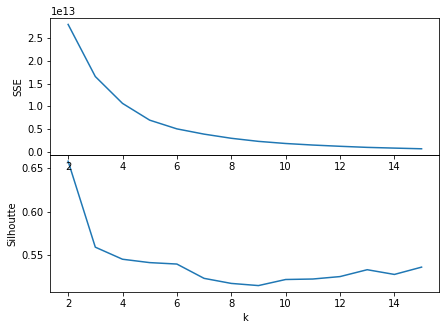

In [21]:
plot_silhouettes_and_sses(audio_tracks, 15)

Parece haber dado muy parecido a audio_features.

In [22]:
sils_sses = []
for k in range(3, 7):
    sils_sses.append([k, get_silhouette_avg(audio_tracks, k), get_sse(audio_tracks, k)])
pd.DataFrame(sils_sses, columns=['k', 'silhouette', 'sse'])

,k,silhouette,sse
0,3,0.558905,1.653062e+13
1,4,0.544984,1.065855e+13
2,5,0.541088,6.989516e+12
3,6,0.539424,5.084332e+12


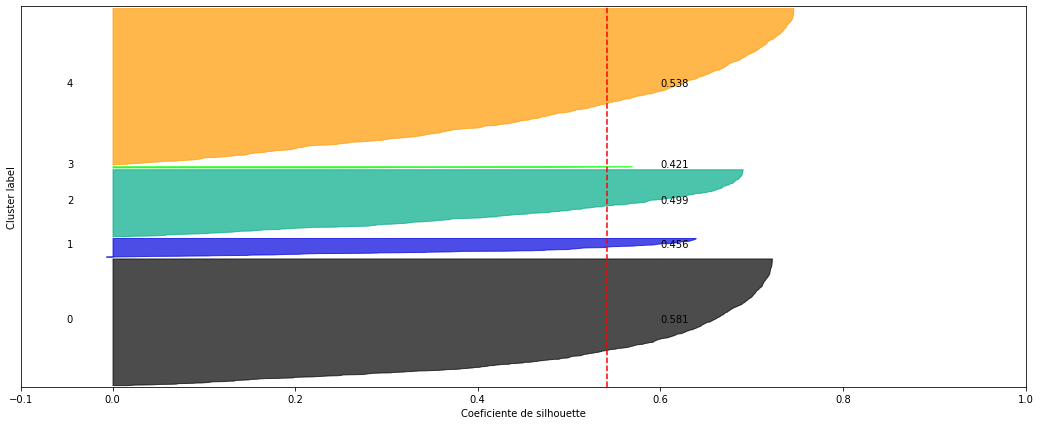

In [23]:
plot_silhouette(audio_tracks, 5)

De vuelta, audio_tracks da prácticamente lo mismo que audio_features. Parece que los summaries de audio_analysis no influyen mucho en los resultados de KMeans.

## b) Evaluar si los agrupamientos son similares para los distintos conjuntos de datos utilizando la matriz de confusión y los índices de Rand y van Dongen en los casos que correspondan

### Matrices de confusión

In [24]:
# Para que las comparaciones sean del mismo largo,
# se remueve de audio_feature el track que no se encuentra en audio_analysis
merged = audio_features.merge(audio_analysis_original, how = 'left', on = 'id')
id_to_remove = merged[merged.timbre_mean_0.isnull()].index[0]
audio_features_minus_one = audio_features.drop(id_to_remove, axis = 0)
audio_features_minus_one.shape

(2205, 13)

In [25]:
# Se ordenan los tres datasets para que los tracks estén en el mismo orden
audio_features_sorted = audio_features_minus_one.sort_index()
audio_analysis_sorted = audio_analysis_original.sort_index()
audio_tracks_sorted = audio_tracks.sort_index()

In [26]:
# Vamos a comparar todos los KMeans con k = 5
km_audio_features = KMeans(n_clusters = 5, random_state = 0).fit(audio_features_sorted)
km_audio_analysis = KMeans(n_clusters = 5, random_state = 0).fit(audio_analysis_sorted)
km_audio_tracks = KMeans(n_clusters = 5, random_state = 0).fit(audio_tracks_sorted)

In [27]:
# Matriz de confusión: audio_features VS audio_analysis
tmp1 = pd.DataFrame({'audio_features': km_audio_features.labels_, 'audio_analysis': km_audio_analysis.labels_})
ct1 = pd.crosstab(tmp1['audio_features'], tmp1['audio_analysis'])
ct1

audio_analysis,0,1,2,3,4
audio_features,,,,,
0,240,59,142,366,124
1,187,92,157,139,183
2,0,1,1,2,4
3,19,11,19,11,48
4,109,34,84,84,89


In [28]:
# Matriz de confusión: audio_features VS audio_tracks
tmp2 = pd.DataFrame({'audio_features': km_audio_features.labels_, 'audio_tracks': km_audio_tracks.labels_})
ct2 = pd.crosstab(tmp2['audio_features'], tmp2['audio_tracks'])
ct2

audio_tracks,0,1,2,3,4
audio_features,,,,,
0,931,0,0,0,0
1,0,758,0,0,0
2,0,0,8,0,0
3,0,0,0,108,0
4,0,0,0,0,400


In [29]:
# Matriz de confusión: audio_tracks VS audio_analysis
tmp3 = pd.DataFrame({'audio_tracks': km_audio_tracks.labels_, 'audio_analysis': km_audio_analysis.labels_})
ct3 = pd.crosstab(tmp3['audio_tracks'], tmp3['audio_analysis'])
ct3

audio_analysis,0,1,2,3,4
audio_tracks,,,,,
0,240,59,142,366,124
1,187,92,157,139,183
2,0,1,1,2,4
3,19,11,19,11,48
4,109,34,84,84,89


Como ya se había visto, el etiquetado de audio_features es exactamente igual que el etiquetado de audio_tracks. Lo que significa que a KMeans le da lo mismo que las variables resumen de audio_analysis estén o no en el dataset.

Los elementos que están en la diagonal son los aciertos. O sea: los que ambos modelos que se están comparando etiquetaron igual.

### Criterio de van Dongen

In [30]:
vanDongen(ct1)

0.9238790406673618

In [31]:
vanDongen(ct2)

0.0

In [32]:
vanDongen(ct3)

0.9238790406673618

### Índices Rand

In [33]:
# audio_features VS audio_analysis
adjusted_rand_score(km_audio_features.labels_, km_audio_analysis.labels_)

0.033385365257147144

In [34]:
# audio_features VS audio_tracks
adjusted_rand_score(km_audio_features.labels_, km_audio_tracks.labels_)

1.0

In [35]:
# audio_analysis VS audio_tracks
adjusted_rand_score(km_audio_analysis.labels_, km_audio_tracks.labels_)

0.033385365257147144

## c) Evaluar para los mejores casos si los clusters se coindicen con el género (columna de metadata)

Se testea primero con el que se cree que fue clustering, el de audio_features.

In [36]:
# Se remueve el track que no está en audio_analysis
metadata_minus_one = metadata_original.drop(id_to_remove, axis = 0)

# Se ordenan los index de metadata
metadata_sorted = metadata_minus_one.sort_index()
metadata_sorted.shape

(2205, 17)

In [37]:
# Se calcula la matriz de confusión
tmp4 = pd.DataFrame({'Generos': metadata_sorted.genre, 'audio_features': km_audio_features.labels_})
ct4 = pd.crosstab(tmp4['Generos'], tmp4['audio_features'])
ct4

audio_features,0,1,2,3,4
Generos,,,,,
ambient,163,149,1,22,125
classical,108,164,5,47,81
drum-and-bass,332,64,1,0,54
jazz,146,164,0,25,91
world-music,182,217,1,14,49


In [38]:
# Se calcula el criterio de van Dongen
vanDongen(ct4)

0.876657824933687

In [39]:
# Se calcula el índice de rand
adjusted_rand_score(metadata_sorted.genre, km_audio_features.labels_)

0.04620982672411453

Se testea también, por las dudas, audio_analysis.

In [40]:
# Se calcula la matriz de confusión
tmp5 = pd.DataFrame({'Generos': metadata_sorted.genre, 'audio_analysis': km_audio_analysis.labels_})
ct5 = pd.crosstab(tmp5['Generos'], tmp5['audio_analysis'])
ct5

audio_analysis,0,1,2,3,4
Generos,,,,,
ambient,105,121,150,19,65
classical,13,25,132,13,222
drum-and-bass,37,0,0,405,9
jazz,168,11,84,66,97
world-music,232,40,37,99,55


In [41]:
# Se calcula el criterio de van Dongen
vanDongen(ct5)

0.6286995515695067

In [42]:
# Se calcula el índice de rand
adjusted_rand_score(metadata_sorted.genre, km_audio_analysis.labels_)

0.2332619364504702

Efectivamente las validaciones externas nos muestran que los clusters generados con audio_features fueron mejores.

## d) Visualizar los clusters y las etiquetas de género en baja dimensión con alguna técnica de reducción (PCA, TSNE, MDS, etc)

In [43]:
genres = []
for genre in metadata_sorted.genre:
    if genre == 'ambient':
        genres.append(0)
    if genre == 'classical':
        genres.append(1)
    if genre == 'drum-and-bass':
        genres.append(2)
    if genre == 'jazz':
        genres.append(3)
    if genre == 'world-music':
        genres.append(4)
len(genres)

2205

## TSNE

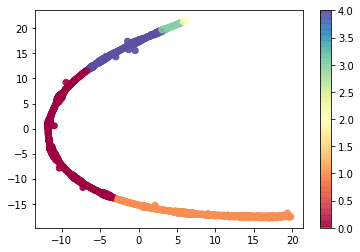

In [46]:
tsne = TSNE(n_components=2,perplexity=200)
Xred = tsne.fit_transform(audio_features_sorted)
plt.scatter(Xred[:,0], Xred[:,1], c=km_audio_features.labels_, cmap=plt.cm.Spectral, alpha=0.7)
plt.colorbar()

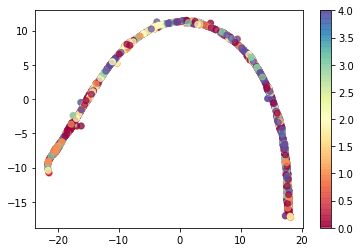

In [51]:
tsne = TSNE(n_components=2,perplexity=200)
Xred = tsne.fit_transform(audio_features_sorted)
plt.scatter(Xred[:,0], Xred[:,1], c=genres, cmap=plt.cm.Spectral, alpha=0.7)
plt.colorbar()

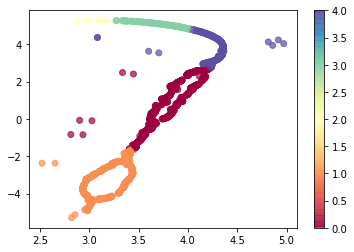

In [47]:
tsne = TSNE(n_components=2,perplexity=1000)
Xred = tsne.fit_transform(audio_features_sorted)
plt.scatter(Xred[:,0], Xred[:,1], c=km_audio_features.labels_, cmap=plt.cm.Spectral, alpha=0.7)
plt.colorbar()

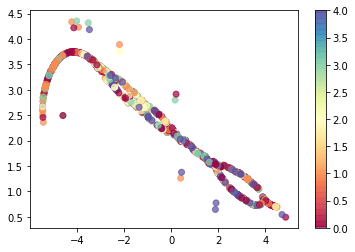

In [52]:
tsne = TSNE(n_components=2,perplexity=1000)
Xred = tsne.fit_transform(audio_features_sorted)
plt.scatter(Xred[:,0], Xred[:,1], c=genres, cmap=plt.cm.Spectral, alpha=0.7)
plt.colorbar()

## UMAP

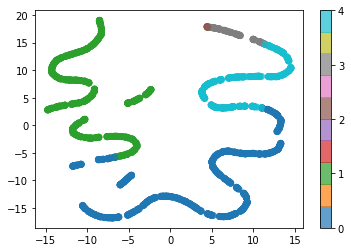

In [48]:
um = UMAP()
Xred = um.fit_transform(audio_features_sorted)
plt.scatter(Xred[:,0],Xred[:,1],c=km_audio_features.labels_,cmap=plt.cm.tab10,alpha=0.7)
plt.colorbar(ticks=range(6));

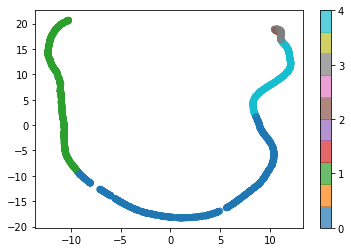

In [50]:
um = UMAP(n_neighbors = 200)
Xred = um.fit_transform(audio_features_sorted)
plt.scatter(Xred[:,0],Xred[:,1],c=km_audio_features.labels_,cmap=plt.cm.tab10,alpha=0.7)
plt.colorbar(ticks=range(6));

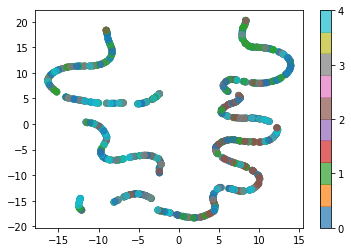

In [53]:
um = UMAP()
Xred = um.fit_transform(audio_features_sorted)
plt.scatter(Xred[:,0],Xred[:,1],c=genres,cmap=plt.cm.tab10,alpha=0.7)
plt.colorbar(ticks=range(6));

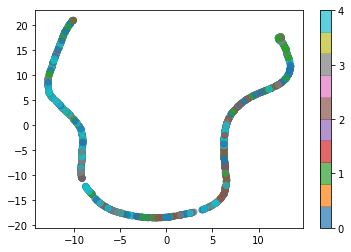

In [54]:
um = UMAP(n_neighbors = 200)
Xred = um.fit_transform(audio_features_sorted)
plt.scatter(Xred[:,0],Xred[:,1],c=genres,cmap=plt.cm.tab10,alpha=0.7)
plt.colorbar(ticks=range(6));